Few-View CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a
few-view CT reconstruction problem with anisotropic total variation
(TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is
a 2D finite difference operator, and $\mathbf{x}$ is the desired
image.

In [1]:
import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon_astra import ParallelBeamProjector
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1, N, angles)  # Radon transform operator
y = A @ x_gt  # sinogram

Set up ADMM solver object.

In [4]:
λ = 2e-0  # L1 norm regularization parameter
ρ = 5e-0  # ADMM penalty parameter
maxiter = 25  # number of ADMM iterations
num_inner_iter = 20  # number of CG iterations per ADMM iteration

g = λ * functional.L1Norm()  # regularization functionals gi
C = linop.FiniteDifference(input_shape=x_gt.shape)  # analysis operators Ci

f = loss.SquaredL2Loss(y=y, A=A)

x0 = snp.clip(A.fbp(y), 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": num_inner_iter}),
    verbose=True,
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_reconstruction = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.33e+00  9.391e+03    1.148e+02  3.146e+02


   1  3.57e+00  4.729e+03    1.209e+02  2.308e+01


   2  3.87e+00  7.113e+03    6.252e+01  2.249e+01


   3  4.17e+00  1.319e+04    4.410e+01  2.401e+01


   4  4.46e+00  1.859e+04    3.560e+01  2.205e+01


   5  4.74e+00  2.300e+04    2.868e+01  2.018e+01


   6  5.01e+00  2.624e+04    2.551e+01  1.831e+01


   7  5.32e+00  2.809e+04    2.205e+01  1.497e+01


   8  5.60e+00  2.943e+04    1.999e+01  1.497e+01


   9  5.87e+00  3.011e+04    1.798e+01  1.202e+01


  10  6.12e+00  3.047e+04    1.689e+01  1.180e+01


  11  6.39e+00  3.081e+04    1.555e+01  1.071e+01


  12  6.65e+00  3.090e+04    1.457e+01  1.015e+01


  13  6.89e+00  3.109e+04    1.363e+01  9.536e+00


  14  7.16e+00  3.112e+04    1.279e+01  8.850e+00


  15  7.41e+00  3.126e+04    1.196e+01  9.312e+00


  16  7.67e+00  3.124e+04    1.120e+01  7.943e+00


  17  7.92e+00  3.134e+04    1.080e+01  7.970e+00


  18  8.18e+00  3.134e+04    1.022e+01  7.028e+00


  19  8.44e+00  3.141e+04    9.767e+00  6.915e+00


  20  8.76e+00  3.140e+04    9.307e+00  6.377e+00


  21  9.00e+00  3.145e+04    8.891e+00  6.330e+00


  22  9.29e+00  3.144e+04    8.504e+00  5.946e+00


  23  9.55e+00  3.149e+04    8.152e+00  5.917e+00


  24  9.80e+00  3.148e+04    7.814e+00  5.575e+00


Show the recovered image.

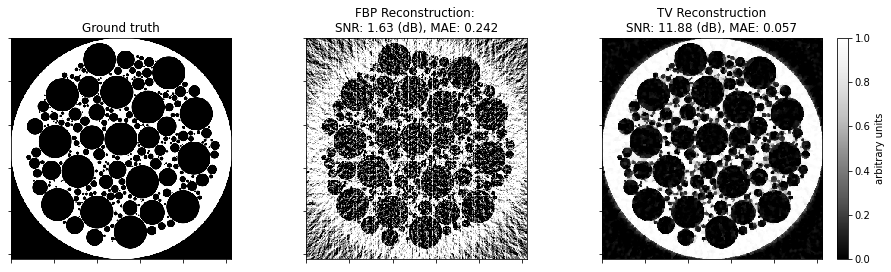

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    x0,
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x0), metric.mae(x_gt, x0)),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    x_reconstruction,
    title="TV Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (metric.snr(x_gt, x_reconstruction), metric.mae(x_gt, x_reconstruction)),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics.

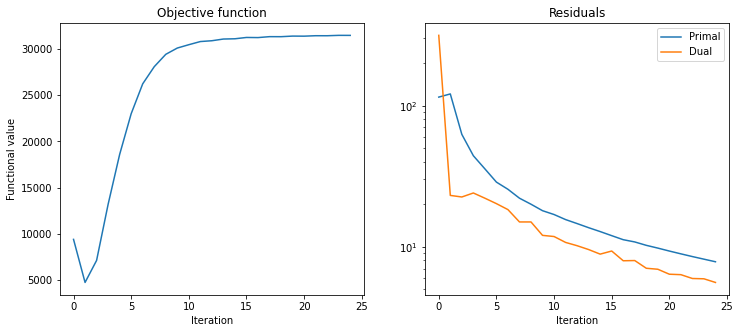

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()